# BERT-based approach for Humor Detection - Group 16

Age, gender, and socioeconomic background are all known to influence how people interpret jokes, making humor appreciation another highly subjective topic. Due to its emphasis on numerous word senses, and more importantly cultural understanding, humor, like most figurative language, presents interesting linguistic problems to explore in our course project. 


Models built can be deployed in chatbots and AI, and hence humor detecting systems are currently in high demand in the research space. We still think it's challenging to determine someone's sense of humor. These figurative languages rely on the reader or listener understanding the context. Since the dataset we are using has important features quanitifed, it had a significant impact on the accurate outcomes.


We’ve framed the problem essentially as a text classifier, hoping to classify a given text as humorous or not, being our expected end result. We experimented with BERT model and its variants ALBERT and RoBERTa models. Along with different variants of BERT model, we also explored building LSTM and GRU models with and without initialized weights. We visualized metrics such as accuracy, precision, f1-score and confusion matrices to compare the performance of these models.

# 1. Import Required Libraries

In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords, wordnet
from tqdm.notebook import tqdm
import pickle
import string
import re
import math
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import WordNetLemmatizer
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, GRU, Conv1D, Dense, Input, Bidirectional, Dropout, SpatialDropout1D, MaxPooling1D, Flatten, BatchNormalization
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import TFBertModel, TFAlbertModel, TFRobertaModel, BertTokenizerFast, AlbertTokenizerFast, RobertaTokenizerFast
from sklearn.metrics import *
from keras.callbacks import History 
import warnings
warnings.filterwarnings('ignore')
import logging
tf.get_logger().setLevel(logging.ERROR)
history = History()
%matplotlib inline

[nltk_data] Downloading package punkt to /Users/sighorzki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sighorzki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sighorzki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/sighorzki/miniforge3/envs/sumNLP/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. EDA of the dataset

In [2]:
train_data = pd.read_csv('humor_train.txt') 
val_data = pd.read_csv('humor_val.txt')
test_data = pd.read_csv('humor_test.txt')

In [3]:
train_data.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [4]:
train_data[['is_humor', 'humor_rating', 'humor_controversy', 'offense_rating']].describe()

,is_humor,humor_rating,humor_controversy,offense_rating
count,8000.000000,4932.000000,4932.000000,8000.000000
mean,0.616500,2.260525,0.499797,0.585325
std,0.486269,0.566974,0.500051,0.979955
min,0.000000,0.100000,0.000000,0.000000
25%,0.000000,1.890000,0.000000,0.000000
50%,1.000000,2.280000,0.000000,0.100000
75%,1.000000,2.650000,1.000000,0.700000
max,1.000000,4.000000,1.000000,4.850000


<AxesSubplot:xlabel='is_humor', ylabel='count'>

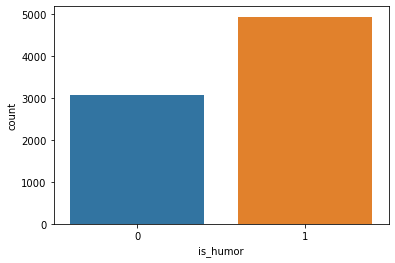

In [5]:
sns.countplot(x='is_humor', data=train_data)

We can observe that the training data set have 4932 humorous texts out of 8000 total, which is more than a half.

<AxesSubplot:xlabel='humor_controversy', ylabel='count'>

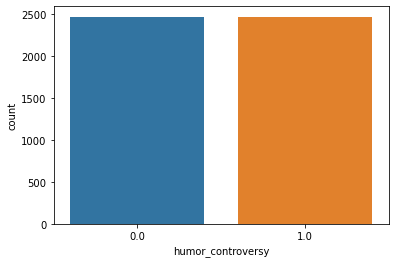

In [6]:
sns.countplot(x='humor_controversy', data=train_data)

We can observe an equal amount of controversial and non-controversial texts were found to be humorous.

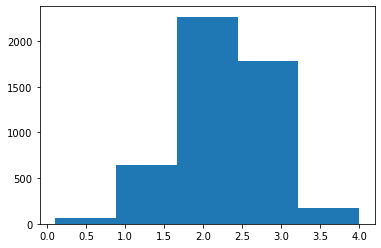

In [7]:
# Distribution of humor rating in the data set
humor_ratings = train_data['humor_rating'].values
plt.hist(humor_ratings, bins=5)
plt.show()

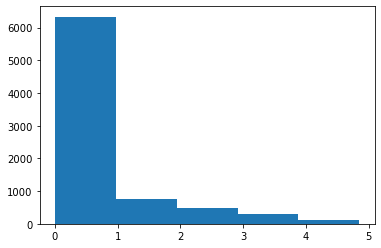

In [8]:
# Distribution of offense rating in the data set
offense_ratings = train_data['offense_rating'].values
plt.hist(offense_ratings, bins=5)
plt.show()

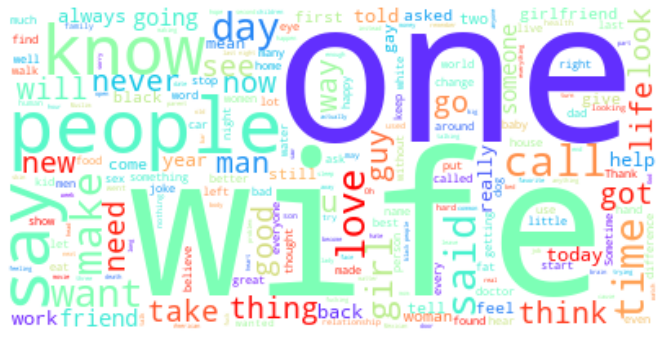

In [9]:
#Generating word cloud for training data
plt.figure(figsize=(12, 6))
wc = WordCloud(colormap="rainbow", background_color="white").generate(" ".join(train_data['text']))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3. Preprocess the dataset

In [10]:
def preprocess_text(text):
    """
    Receives texts and returns clean word-list
    """
    # convert to lower case
    text = text.lower()
    # cleaning: non-ASCII filtering, appostrophes etc.
    text = re.sub(r"’", r"'", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\*", "", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\=", " ", text)
    text = re.sub(r":", " ", text)
    text = re.sub(r";", " ", text)
    text = re.sub(r"\"", " ", text)
    text = re.sub(r"“", " ", text)
    text = re.sub(r"\&", " ", text)
    text = re.sub(r"\?", " ", text)
    text = re.sub(r"\(", " ", text)
    text = re.sub(r"\)", " ", text)
    text = re.sub(r"-", " ", text)
    text = re.sub(r"”", " ", text)
    text = re.sub(r"%", " ", text)
    text = re.sub(r"‘", "'", text)
    text = re.sub(r"@", " ", text)
    text = re.sub(r"\$", " ", text)
    text = re.sub(r"–", " ", text)
    text = re.sub(r"£", " ", text)
    text = re.sub(r"{", " ", text)
    text = re.sub(r"}", " ", text)
    text = re.sub(r"・", " ", text)
    text = re.sub(r"\.{3}", " ", text)
    text = re.sub(r"„", " ", text)
    text = re.sub(r"\s{2,}", " ", text)

    tokenizer = TweetTokenizer()
    words = tokenizer.tokenize(text)

    contractions = {"aren't": "are not", "can't": "cannot", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not",
                  "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
                  "i'd": "i would", "i'll": "i will", "i'm": "i am", "isn't": "is not", "it's": "it is", "it'll": "it will",
                  "i've": "i have", "let's": "let us", "mightn't": "might not", "mustn't": "must not", "shan't": "shall not", "she'd": "she would",
                  "she'll": "she will", "she's": "she is", "shouldn't": "should not", "that's": "that is", "there's": "there is", "they'd": "they would",
                  "they'll": "they will", "they're": "they are", "they've": "they have", "we'd": "we would", "we're": "we are", "weren't": "were not",
                  "we've": "we have", "what'll": "what will", "what're": "what are", "what's": "what is", "what've": "what have", "where's": "where is",
                  "who'd": "who would", "who'll": "who will", "who're": "who are", "who's": "who is", "who've": "who have", "won't": "will not",
                  "wouldn't": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are", "you've": "you have", "'re": " are",
                  "wasn't": "was not", "we'll": "we will"}
    words = [contractions[word] if word in contractions else word for word in words]

    clean_text = " ".join(words)
    clean_text = re.sub("  ", " ", clean_text)
    return clean_text

In [11]:
train_data['text'] = train_data['text'].apply(lambda x: preprocess_text(x))
val_data['text'] = val_data['text'].apply(lambda x: preprocess_text(x))
test_data['text'] = test_data['text'].apply(lambda x: preprocess_text(x))

# 3.2. Split data

In [12]:
X_train = train_data['text']
y_train = train_data['is_humor']
count = sum([len(i.split()) for i in X_train])
avg_length = math.ceil(count/len(X_train))
print("Average length of all the texts is:", avg_length)
X_val = val_data['text']
y_val = val_data['is_humor']
X_test = test_data['text']
y_test = test_data['is_humor']

Average length of all the texts is: 22


In [13]:
X = X_train
X = X.append(X_val, ignore_index=True)
X = X.append(X_test, ignore_index=True)
y_train = np.array(y_train)
y_train = y_train.reshape(-1, 1)
y_val = np.array(y_val)
y_val = y_val.reshape(-1, 1)
y_test = np.array(y_test)
y_test = y_test.reshape(-1, 1)

# 3.3. Using glove vectors for embedding

In [14]:
def load_embeddings(file_name, vocabulary):
    """
    Loads word embeddings from the file with the given name.
    :param file_name: name of the file containing word embeddings
    :type file_name: str
    :param vocabulary: captions vocabulary
    :type vocabulary: numpy.array
    :return: word embeddings
    :rtype: dict
    """
    embeddings = dict()
    with open(file_name, 'r', encoding='utf-8') as doc:
        line = doc.readline()
        while line != '':
            line = line.rstrip('\n').lower()
            parts = line.split(' ')
            vals = np.array(parts[1:], dtype=np.float)
            if parts[0] in vocabulary:
                embeddings[parts[0]] = vals
            line = doc.readline()
        return embeddings

In [15]:
def load_embedding_weights(vocabulary, embedding_size):
    """
    Creates and loads embedding weights.
    :param vocabulary: captions vocabulary
    :type vocabulary: numpy.array
    :param embedding_size: embedding size
    :type embedding_size: int
    :return: embedding weights
    :rtype: numpy.array
    """
    if os.path.exists('embedding_matrix.pkl'):
        with open('embedding_matrix.pkl', 'rb') as f:
            embedding_matrix = pickle.load(f)
    else:
        print('Creating embedding weights...')
        embeddings = load_embeddings(f'glove.twitter.27B.{embedding_size}d.txt', vocabulary)
        embedding_matrix = np.zeros((len(vocabulary), embedding_size))
        for i in range(len(vocabulary)):
            if vocabulary[i] in embeddings.keys():
                embedding_matrix[i] = embeddings[vocabulary[i]]
            else:
                embedding_matrix[i] = np.random.standard_normal(embedding_size)
        with open('embedding_matrix.pkl', 'wb') as f:
            pickle.dump(embedding_matrix, f)
    return embedding_matrix

In [16]:
# Setting tokenizer properties
vocabulary_size = 20000
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

In [17]:
# Setting the padding properties
max_length = 50
trunc_type = 'post'
padding_type = 'post'

In [18]:
# Creating padded sequences from train and test data
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(X_val)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
all_sequences = tokenizer.texts_to_sequences(X)
all_padded = pad_sequences(all_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [19]:
vocabulary = list(word_index.keys())
vocabulary.insert(0, '<tok>')
vocabulary_size = len(vocabulary)

In [20]:
embedding_weights = load_embedding_weights(vocabulary, 100)
embedding_dim = 100

In [21]:
# Converting the lists to numpy arrays for Tensorflow 2.x
training_padded = np.array(training_padded)
validation_padded = np.array(validation_padded)
testing_padded = np.array(testing_padded)

# 4. Developing LSTM and GRU models

In [22]:
def build_LSTM1(vocabulary_size, max_len):
    """
    Builds Model with Embedding layer without initialized weights
    :param vocabulary_size: captions vocabulary size
    :type vocabulary_size: int
    :param max_len: input length
    :type vocabulary: int
    :return: model
    """
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=max_len))
    model.add(Dropout(0.3))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
    model.summary()
    return model

In [23]:
def build_LSTM2(vocabulary_size, max_len, embedding_matrix):
    """
    Builds Model with Embedding layer with initialized weights (without training)
    :param vocabulary_size: captions vocabulary size
    :type vocabulary_size: int
    :param max_len: input length
    :type vocabulary: int
    :param embedding_matrix: weights
    :type embedding_matrix: numpy.array
    :return: model
    """
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=False))
    model.add(Dropout(0.3))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
    model.summary()
    return model

In [24]:
def build_LSTM3(vocabulary_size, max_len, embedding_matrix):
    """
    Builds Model with Embedding layer with initialized weights (with training)
    :param vocabulary_size: captions vocabulary size
    :type vocabulary_size: int
    :param max_len: input length
    :type vocabulary: int
    :param embedding_matrix: weights
    :type embedding_matrix: numpy.array
    :return: model
    """
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
    model.summary()
    return model

In [25]:
def build_GRU1(vocabulary_size, max_len):
    """
    Builds Model with Embedding layer without initialized weights
    :param vocabulary_size: captions vocabulary size
    :type vocabulary_size: int
    :param max_len: input length
    :type vocabulary: int
    :return: model
    """
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=max_len))
    model.add(Dropout(0.3))
    model.add(GRU(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
    model.summary()
    return model

In [26]:
def build_GRU2(vocabulary_size, max_len, embedding_matrix):
    """
    Builds Model with Embedding layer with initialized weights (without training)
    :param vocabulary_size: captions vocabulary size
    :type vocabulary_size: int
    :param max_len: input length
    :type vocabulary: int
    :param embedding_matrix: weights
    :type embedding_matrix: numpy.array
    :return: model
    """
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=False))
    model.add(Dropout(0.3))
    model.add(GRU(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
    model.summary()
    return model

In [27]:
def build_GRU3(vocabulary_size, max_len, embedding_matrix):
    """
    Builds Model with Embedding layer with initialized weights (without training)
    :param vocabulary_size: captions vocabulary size
    :type vocabulary_size: int
    :param max_len: input length
    :type vocabulary: int
    :param embedding_matrix: weights
    :type embedding_matrix: numpy.array
    :return: model
    """
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
    model.add(Dropout(0.3))
    model.add(GRU(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
    model.summary()
    return model

# 4.1. Helper methods to generate metrics

In [28]:
def plot_graph_model_metrics(history):
    """
    Evaluating Accuracy and Loss of the model
    :param history: history callback of the model
    """
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision = history.history['precision']
    val_precision = history.history['val_precision']    
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs = range(len(accuracy)) # Number of epochs

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Plot training and validation precision per epoch
    plt.plot(epochs, precision, label='Training Precision')
    plt.plot(epochs, val_precision, label='Validation Precision')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.show()
    
    # Plot training and validation recall per epoch
    plt.plot(epochs, recall, label='Training Recall')
    plt.plot(epochs, val_recall, label='Validation Recall')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.show()
    
    # Plot training and validation auc per epoch
    plt.plot(epochs, auc, label='Training AUC')
    plt.plot(epochs, val_auc, label='Validation AUC')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.show()

In [29]:
def calculate_metrics_classification(y_test, y_predicted):
    """
    Calculates model metrics based on history callback
    :param y_test: labels of test dataset
    :type y_test: numpy.array
    :param y_predicted: weights
    :type y_predicted: labels of predicted set
    """
    print(classification_report(y_test, y_predicted))
    plt.figure(figsize=(7,7))
    sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True, fmt='.5g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion matrix')
    plt.show()

# LSTM Model 1 - Model with Embedding layer without initialized weights

In [30]:
lstm_model1 = build_LSTM1(vocabulary_size, max_length)
history = lstm_model1.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_val), verbose=1)

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1665800   
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,682,857
Trainable params: 1,682,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 10s 34ms/step - loss: 0.5702 - accuracy: 0.7078 - precision: 0.6925 - recall: 0.9459 - auc: 0.

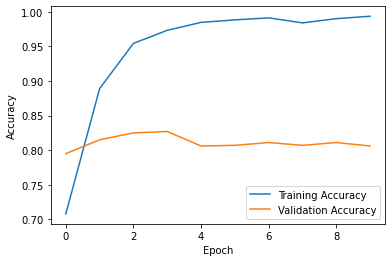

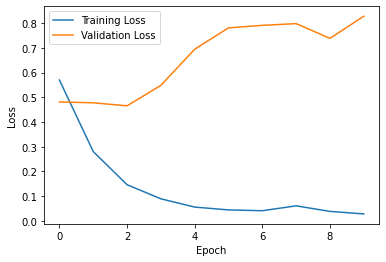

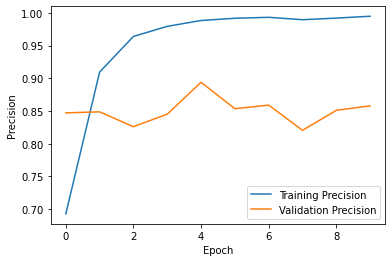

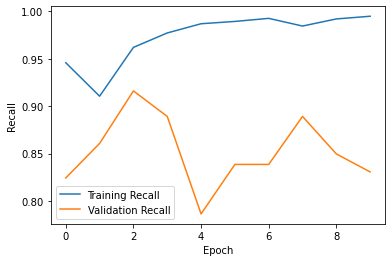

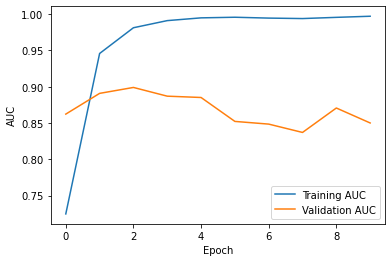

In [31]:
plot_graph_model_metrics(history)

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       385
           1       0.84      0.79      0.82       615

    accuracy                           0.78      1000
   macro avg       0.77      0.78      0.77      1000
weighted avg       0.79      0.78      0.78      1000



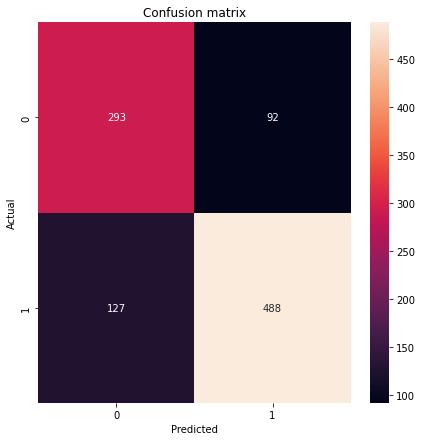

In [32]:
predictions = lstm_model1.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

In [33]:
with open('LSTM1.pkl', 'wb') as f:  
    pickle.dump(lstm_model1, f)

# LSTM Model 2 - Model with Embedding layer with initialized weights (without training)

In [34]:
lstm_model2 = build_LSTM2(vocabulary_size, max_length, embedding_weights)
history = lstm_model2.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_val), verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           1665800   
                                                                 
 dropout_1 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,682,857
Trainable params: 17,057
Non-trainable params: 1,665,800
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 7s 23ms/step - loss: 0.6382 - accuracy: 0.6433 - precision: 0.6445 - recall: 0.9398 - auc: 0.6140 - val_loss: 0.5289 

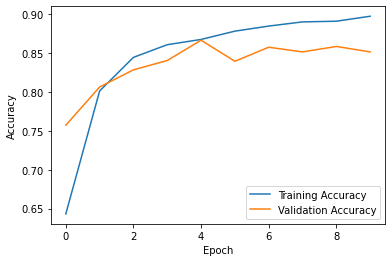

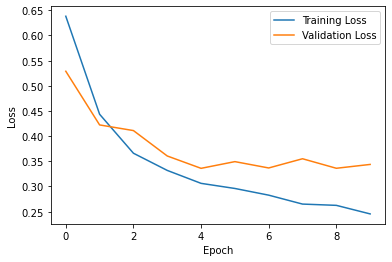

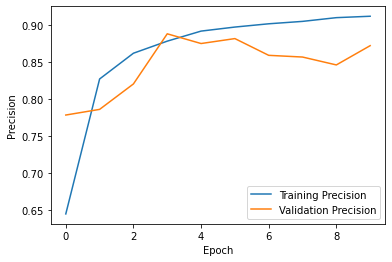

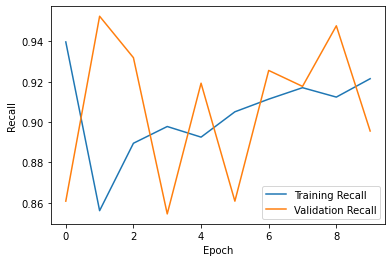

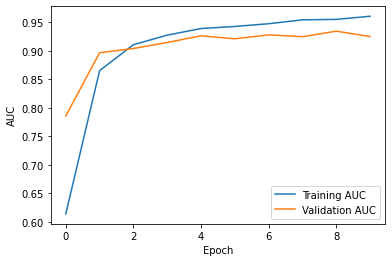

In [35]:
plot_graph_model_metrics(history)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       385
           1       0.88      0.89      0.88       615

    accuracy                           0.86      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.86      0.86      0.86      1000



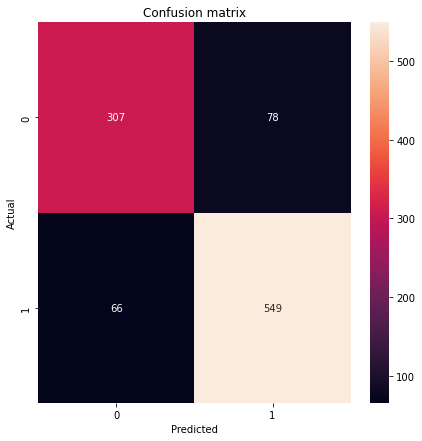

In [36]:
predictions = lstm_model2.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

In [37]:
with open('LSTM2.pkl', 'wb') as f:  
    pickle.dump(lstm_model2, f)

# LSTM Model 3 - Model with Embedding layer with initialized weights (with training)

In [38]:
lstm_model3 = build_LSTM3(vocabulary_size, max_length, embedding_weights)
history = lstm_model3.fit(training_padded, y_train, epochs=20, validation_data=(validation_padded, y_val), verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           1665800   
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                17024     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,682,857
Trainable params: 1,682,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
250/250 [==============================] - 12s 41ms/step - loss: 0.6281 - accuracy: 0.6583 - precision: 0.6527 - recall: 0.9526 - auc: 0.6384 - val_loss: 0.5628 - va

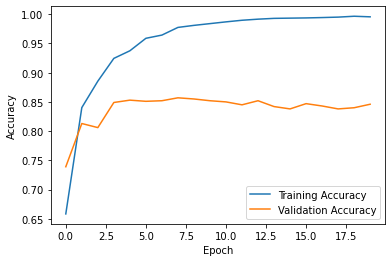

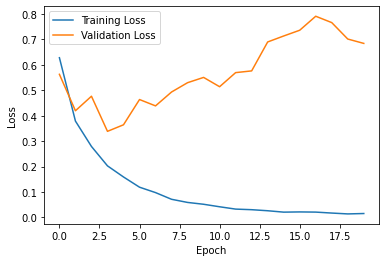

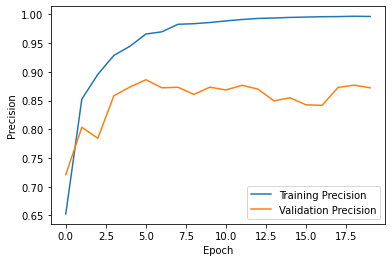

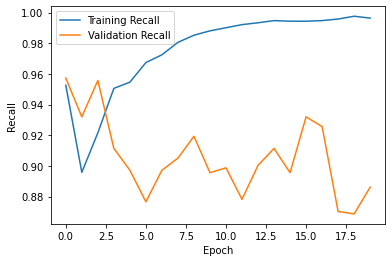

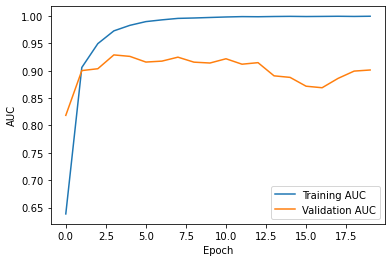

In [39]:
plot_graph_model_metrics(history)

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       385
           1       0.90      0.88      0.89       615

    accuracy                           0.86      1000
   macro avg       0.85      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



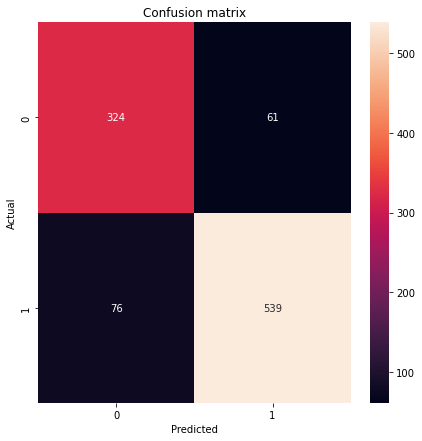

In [40]:
predictions = lstm_model3.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

In [41]:
with open('LSTM3.pkl', 'wb') as f:  
    pickle.dump(lstm_model3, f)

# GRU Model 1 - Model with Embedding layer without initialized weights

In [42]:
gru_model1 = build_GRU1(vocabulary_size, max_length)
history = gru_model1.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_val), verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           1665800   
                                                                 
 dropout_3 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,678,697
Trainable params: 1,678,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 10s 34ms/step - loss: 0.6647 - accuracy: 0.6159 - precision: 0.6163 - recall: 0.9988 - auc: 0.5161 - val_loss: 0.6585 - va

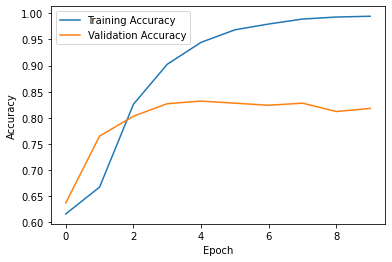

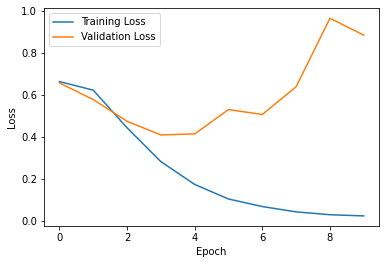

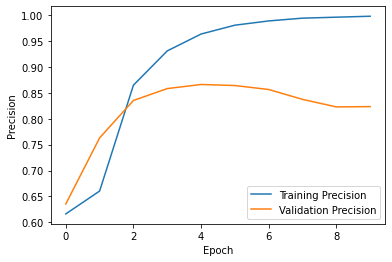

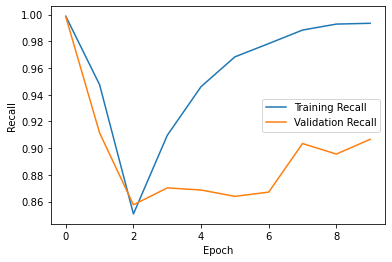

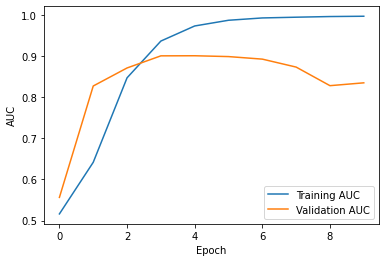

In [43]:
plot_graph_model_metrics(history)

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       385
           1       0.82      0.87      0.84       615

    accuracy                           0.80      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.80      0.80      1000



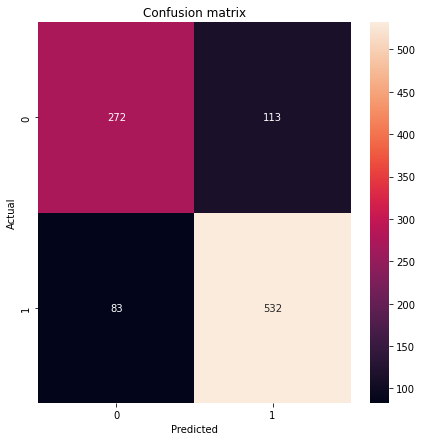

In [44]:
predictions = gru_model1.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

In [45]:
with open('GRU1.pkl', 'wb') as f:  
    pickle.dump(gru_model1, f)

# GRU Model 2 - Model with Embedding layer with initialized weights (without training)

In [46]:
gru_model2 = build_GRU2(vocabulary_size, max_length, embedding_weights)
history = gru_model2.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_val), verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 100)           1665800   
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 32)                12864     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,678,697
Trainable params: 12,897
Non-trainable params: 1,665,800
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 7s 23ms/step - loss: 0.6597 - accuracy: 0.6278 - precision: 0.6322 - recall: 0.9473 - auc: 0.5618 - val_loss: 0.5908 

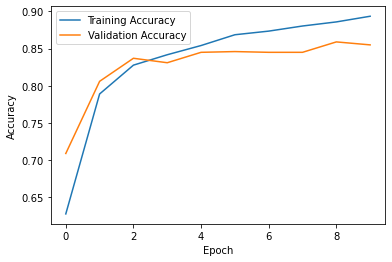

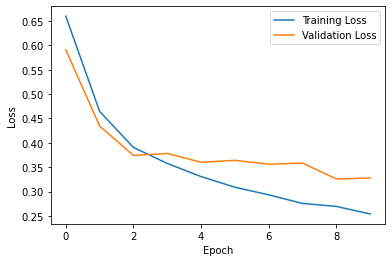

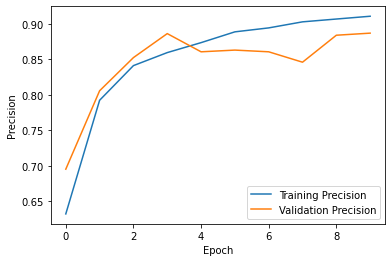

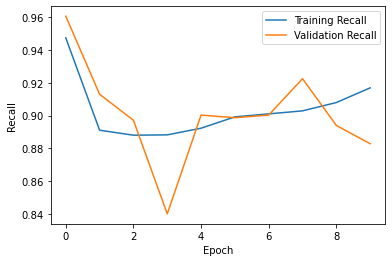

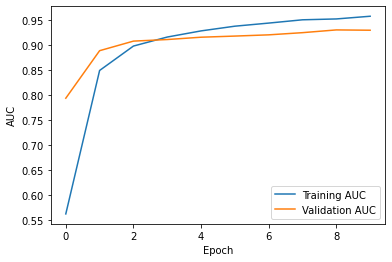

In [47]:
plot_graph_model_metrics(history)

              precision    recall  f1-score   support

           0       0.78      0.85      0.82       385
           1       0.90      0.85      0.88       615

    accuracy                           0.85      1000
   macro avg       0.84      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000



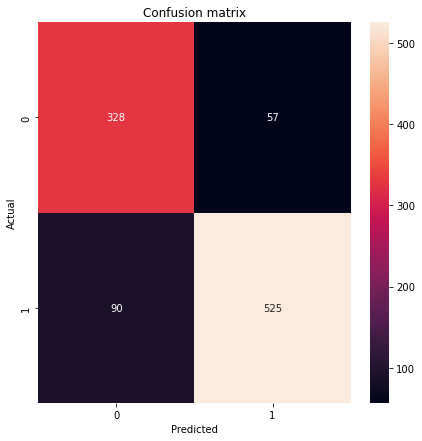

In [48]:
predictions = gru_model2.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

In [49]:
with open('GRU2.pkl', 'wb') as f:  
    pickle.dump(gru_model2, f)

# GRU Model 3 - Model with Embedding layer with initialized weights (with training)

In [50]:
gru_model3 = build_GRU3(vocabulary_size, max_length, embedding_weights)
history = gru_model3.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_val), verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           1665800   
                                                                 
 dropout_5 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru_2 (GRU)                 (None, 32)                12864     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,678,697
Trainable params: 1,678,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 10s 34ms/step - loss: 0.6614 - accuracy: 0.6231 - precision: 0.6289 - recall: 0.9483 - auc: 0.5447 - val_loss: 0.6123 - va

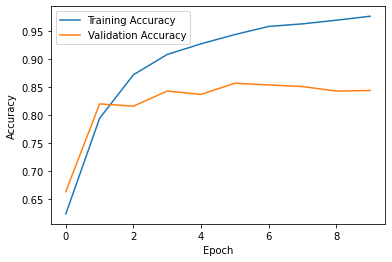

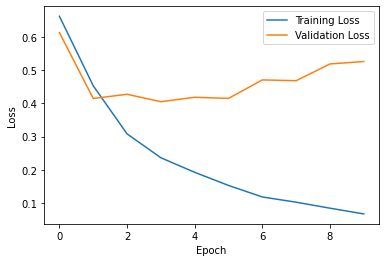

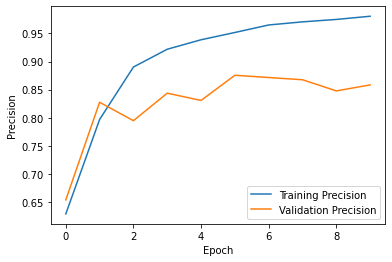

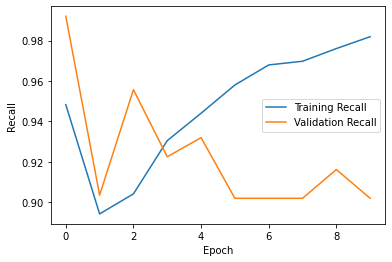

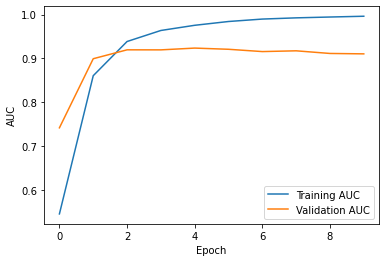

In [51]:
plot_graph_model_metrics(history)

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       385
           1       0.86      0.90      0.88       615

    accuracy                           0.85      1000
   macro avg       0.84      0.83      0.84      1000
weighted avg       0.85      0.85      0.85      1000



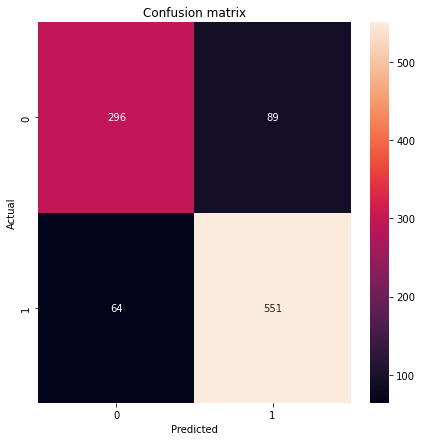

In [52]:
predictions = gru_model3.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

In [53]:
with open('GRU3.pkl', 'wb') as f:  
    pickle.dump(gru_model3, f)

# 5. Developing models using BERT based approach

In [54]:
text_train = list(X_train)
text_val = list(X_val)
text_test = list(X_test)

In [55]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [56]:
train_encodings = bert_tokenizer(text_train, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
val_encodings = bert_tokenizer(text_val, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
test_encodings = bert_tokenizer(text_test, max_length=100, truncation=True, padding="max_length", return_tensors='tf')

In [57]:
print(np.shape(train_encodings["input_ids"]))
print(np.shape(val_encodings["input_ids"]))
print(np.shape(test_encodings["input_ids"]))

(8000, 100)
(1000, 100)
(1000, 100)


# 5.1 BERT Model 1

In [58]:
def bert_model(input_shape):
    model = TFBertModel.from_pretrained('bert-base-uncased')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dropout(0.3)(pooled_output)
    is_humor = layers.Dense(32, activation="relu")(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [59]:
model = bert_model((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [60]:
model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_val),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
500/500 [==============================] - 669s 1s/step - loss: 0.2572 - accuracy: 0.8945 - precision: 0.9095 - recall: 0.9205 - auc: 0.9570 - val_loss: 0.2905 - val_accuracy: 0.8770 - val_precision: 0.8641 - val_recall: 0.9557 - val_auc: 0.9590
Epoch 2/3
500/500 [==============================] - 617s 1s/step - loss: 0.0982 - accuracy: 0.9645 - precision: 0.9714 - recall: 0.9710 - auc: 0.9929 - val_loss: 0.3297 - val_accuracy: 0.8910 - val_precision: 0.8863 - val_recall: 0.9494 - val_auc: 0.9572
Epoch 3/3
500/500 [==============================] - 606s 1s/step - loss: 0.0394 - accuracy: 0.9869 - precision: 0.9902 - recall: 0.9884 - auc: 0.9986 - val_loss: 0.4338 - val_accuracy: 0.8680 - val_precision: 0.8531 - val_recall: 0.9557 - val_auc: 0.9367


              precision    recall  f1-score   support

           0       0.94      0.83      0.88       385
           1       0.90      0.97      0.93       615

    accuracy                           0.91      1000
   macro avg       0.92      0.90      0.91      1000
weighted avg       0.92      0.91      0.91      1000



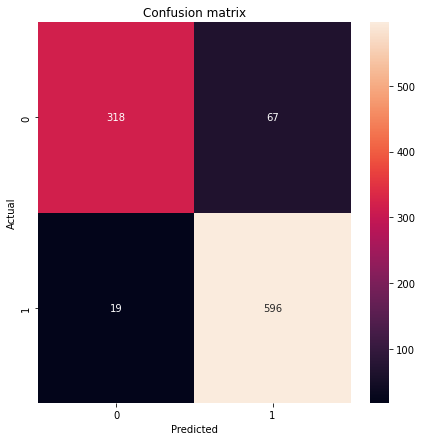

In [61]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

In [62]:
with open('BERT1.pkl', 'wb') as f:  
    pickle.dump(model, f)

# 5.2. BERT Model 2

In [63]:
def bert_model2(input_shape):
    model = TFBertModel.from_pretrained('bert-base-uncased')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dense(64, activation='relu')(pooled_output)
    is_humor = layers.Dropout(0.3)(is_humor)
    is_humor = layers.Dense(32, activation='relu')(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [64]:
model = bert_model2((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                         

In [65]:
model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_val),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
500/500 [==============================] - 653s 1s/step - loss: 0.2789 - accuracy: 0.8865 - precision: 0.8979 - recall: 0.9205 - auc: 0.9492 - val_loss: 0.2701 - val_accuracy: 0.8820 - val_precision: 0.8978 - val_recall: 0.9177 - val_auc: 0.9531
Epoch 2/3
500/500 [==============================] - 1100s 2s/step - loss: 0.1012 - accuracy: 0.9650 - precision: 0.9705 - recall: 0.9728 - auc: 0.9921 - val_loss: 0.3218 - val_accuracy: 0.8790 - val_precision: 0.8614 - val_recall: 0.9636 - val_auc: 0.9533
Epoch 3/3
500/500 [==============================] - 878s 2s/step - loss: 0.0397 - accuracy: 0.9879 - precision: 0.9891 - recall: 0.9913 - auc: 0.9982 - val_loss: 0.4869 - val_accuracy: 0.8560 - val_precision: 0.8389 - val_recall: 0.9557 - val_auc: 0.9377


              precision    recall  f1-score   support

           0       0.91      0.79      0.85       385
           1       0.88      0.95      0.91       615

    accuracy                           0.89      1000
   macro avg       0.90      0.87      0.88      1000
weighted avg       0.89      0.89      0.89      1000



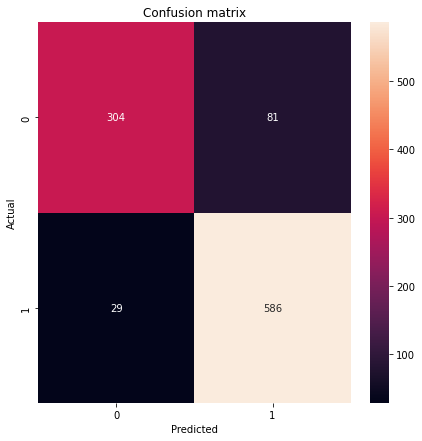

In [66]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

In [67]:
with open('BERT2.pkl', 'wb') as f:  
    pickle.dump(model, f)

# 5.3. ALBERT Model 1

In [68]:
albert_tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

In [69]:
train_encodings = albert_tokenizer(text_train, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
val_encodings = albert_tokenizer(text_val, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
test_encodings = albert_tokenizer(text_test, max_length=100, truncation=True, padding="max_length", return_tensors='tf')

In [70]:
def albert_model(input_shape):
    model = TFAlbertModel.from_pretrained('albert-base-v2')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dropout(0.3)(pooled_output)
    is_humor = layers.Dense(32, activation="relu")(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [71]:
model = albert_model((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
model.summary()

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 albert (TFAlbertMainLayer)     TFBaseModelOutputWi  11683584    ['input_5[0][0]',                
                                thPooling(last_hidd               'input_6[0][0]']                
                                en_state=(None, 100                                               
                                , 768),                                                     

In [72]:
model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_val),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
500/500 [==============================] - 586s 1s/step - loss: 0.3164 - accuracy: 0.8708 - precision: 0.8862 - recall: 0.9067 - auc: 0.9348 - val_loss: 0.3401 - val_accuracy: 0.8390 - val_precision: 0.8161 - val_recall: 0.9620 - val_auc: 0.9415
Epoch 2/3
500/500 [==============================] - 529s 1s/step - loss: 0.1838 - accuracy: 0.9306 - precision: 0.9403 - recall: 0.9477 - auc: 0.9772 - val_loss: 0.2979 - val_accuracy: 0.8770 - val_precision: 0.8921 - val_recall: 0.9161 - val_auc: 0.9427
Epoch 3/3
500/500 [==============================] - 522s 1s/step - loss: 0.1112 - accuracy: 0.9594 - precision: 0.9671 - recall: 0.9670 - auc: 0.9912 - val_loss: 0.4857 - val_accuracy: 0.8400 - val_precision: 0.8155 - val_recall: 0.9652 - val_auc: 0.9297


              precision    recall  f1-score   support

           0       0.95      0.77      0.85       385
           1       0.87      0.98      0.92       615

    accuracy                           0.90      1000
   macro avg       0.91      0.87      0.89      1000
weighted avg       0.90      0.90      0.89      1000



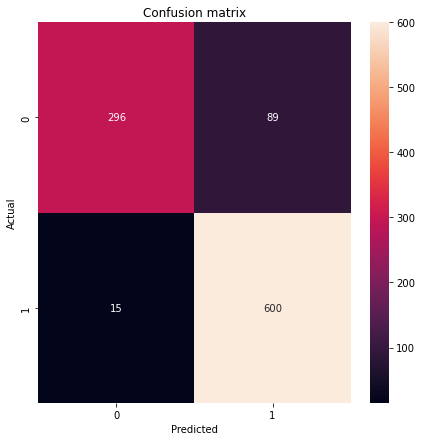

In [73]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

In [74]:
with open('AlBERT1.pkl', 'wb') as f:  
    pickle.dump(model, f)

# 5.4. ALBERT Model 2

In [75]:
def albert_model2(input_shape):
    model = TFAlbertModel.from_pretrained('albert-base-v2')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dense(64, activation='relu')(pooled_output)
    is_humor = layers.Dropout(0.3)(is_humor)
    is_humor = layers.Dense(32, activation='relu')(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [76]:
model = albert_model2((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
model.summary()

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 albert (TFAlbertMainLayer)     TFBaseModelOutputWi  11683584    ['input_7[0][0]',                
                                thPooling(last_hidd               'input_8[0][0]']                
                                en_state=(None, 100                                               
                                , 768),                                                     

In [77]:
model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_val),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
500/500 [==============================] - 1566s 3s/step - loss: 0.3062 - accuracy: 0.8734 - precision: 0.8943 - recall: 0.9011 - auc: 0.9385 - val_loss: 0.2620 - val_accuracy: 0.8910 - val_precision: 0.9171 - val_recall: 0.9098 - val_auc: 0.9559
Epoch 2/3
500/500 [==============================] - 531s 1s/step - loss: 0.1731 - accuracy: 0.9378 - precision: 0.9504 - recall: 0.9485 - auc: 0.9788 - val_loss: 0.3307 - val_accuracy: 0.8630 - val_precision: 0.8689 - val_recall: 0.9225 - val_auc: 0.9349
Epoch 3/3
500/500 [==============================] - 537s 1s/step - loss: 0.2151 - accuracy: 0.8975 - precision: 0.8975 - recall: 0.9412 - auc: 0.9694 - val_loss: 0.3023 - val_accuracy: 0.8660 - val_precision: 0.8507 - val_recall: 0.9557 - val_auc: 0.9465


              precision    recall  f1-score   support

           0       0.94      0.76      0.84       385
           1       0.86      0.97      0.91       615

    accuracy                           0.89      1000
   macro avg       0.90      0.86      0.88      1000
weighted avg       0.89      0.89      0.88      1000



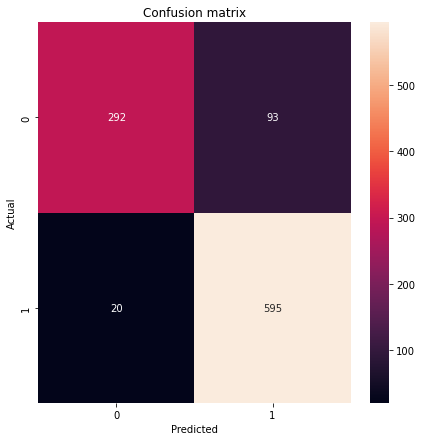

In [78]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

In [79]:
with open('AlBERT2.pkl', 'wb') as f:  
    pickle.dump(model, f)

# 5.5. RoBERTa Model 1

In [80]:
roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

In [81]:
train_encodings = roberta_tokenizer(text_train, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
val_encodings = roberta_tokenizer(text_val, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
test_encodings = roberta_tokenizer(text_test, max_length=100, truncation=True, padding="max_length", return_tensors='tf')

In [82]:
def roberta_model(input_shape):
    model = TFRobertaModel.from_pretrained('roberta-base')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dropout(0.3)(pooled_output)
    is_humor = layers.Dense(32, activation="relu")(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [83]:
model = roberta_model((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 roberta (TFRobertaMainLayer)   TFBaseModelOutputWi  124645632   ['input_9[0][0]',                
                                thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                         

In [84]:
model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_val),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
500/500 [==============================] - 794s 2s/step - loss: 0.2800 - accuracy: 0.8833 - precision: 0.8921 - recall: 0.9221 - auc: 0.9487 - val_loss: 0.2901 - val_accuracy: 0.8700 - val_precision: 0.8496 - val_recall: 0.9652 - val_auc: 0.9569
Epoch 2/3
500/500 [==============================] - 729s 1s/step - loss: 0.1247 - accuracy: 0.9548 - precision: 0.9590 - recall: 0.9680 - auc: 0.9889 - val_loss: 0.2693 - val_accuracy: 0.8960 - val_precision: 0.9125 - val_recall: 0.9241 - val_auc: 0.9546
Epoch 3/3
500/500 [==============================] - 719s 1s/step - loss: 0.0628 - accuracy: 0.9768 - precision: 0.9815 - recall: 0.9807 - auc: 0.9966 - val_loss: 0.3446 - val_accuracy: 0.9040 - val_precision: 0.9123 - val_recall: 0.9383 - val_auc: 0.9487


              precision    recall  f1-score   support

           0       0.91      0.88      0.89       385
           1       0.92      0.95      0.93       615

    accuracy                           0.92      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.92      0.92      1000



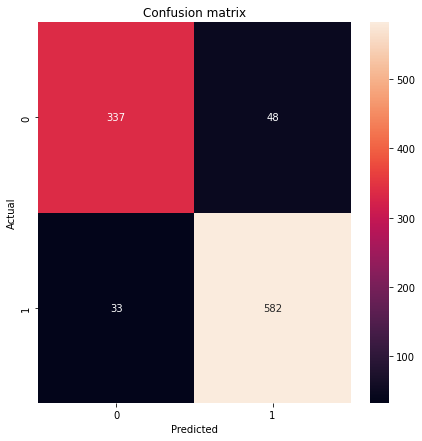

In [85]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

In [86]:
with open('RoBERTa1.pkl', 'wb') as f:  
    pickle.dump(model, f)

# 5.6. RoBERTa Model 2

In [87]:
def roberta_model2(input_shape):
    model = TFRobertaModel.from_pretrained('roberta-base')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dense(64, activation='relu')(pooled_output)
    is_humor = layers.Dropout(0.3)(is_humor)
    is_humor = layers.Dense(32, activation="relu")(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [88]:
model = roberta_model2((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 roberta (TFRobertaMainLayer)   TFBaseModelOutputWi  124645632   ['input_11[0][0]',               
                                thPoolingAndCrossAt               'input_12[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                         

In [89]:
model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_val),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
500/500 [==============================] - 851s 2s/step - loss: 0.3027 - accuracy: 0.8751 - precision: 0.8833 - recall: 0.9189 - auc: 0.9401 - val_loss: 0.2729 - val_accuracy: 0.8710 - val_precision: 0.9024 - val_recall: 0.8924 - val_auc: 0.9522
Epoch 2/3
500/500 [==============================] - 859s 2s/step - loss: 0.1396 - accuracy: 0.9491 - precision: 0.9592 - recall: 0.9582 - auc: 0.9863 - val_loss: 0.3749 - val_accuracy: 0.8830 - val_precision: 0.8884 - val_recall: 0.9320 - val_auc: 0.9320
Epoch 3/3
500/500 [==============================] - 787s 2s/step - loss: 0.0787 - accuracy: 0.9734 - precision: 0.9816 - recall: 0.9751 - auc: 0.9949 - val_loss: 0.3046 - val_accuracy: 0.8860 - val_precision: 0.9497 - val_recall: 0.8655 - val_auc: 0.9556


              precision    recall  f1-score   support

           0       0.83      0.93      0.88       385
           1       0.95      0.88      0.92       615

    accuracy                           0.90      1000
   macro avg       0.89      0.91      0.90      1000
weighted avg       0.91      0.90      0.90      1000



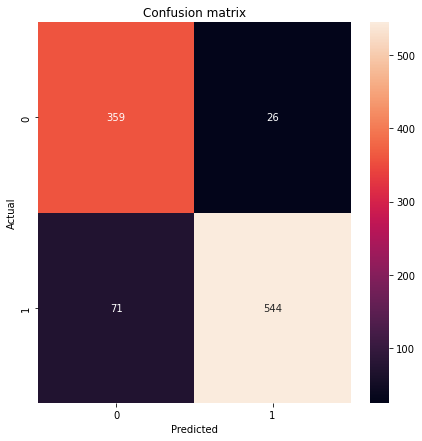

In [90]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

In [91]:
with open('RoBERTa2.pkl', 'wb') as f:  
    pickle.dump(model, f)